# Importing Libraries

In [102]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np

Refer [this blog](https://towardsai.net/p/computer-vision/yolo-v5-object-detection-on-a-custom-dataset) for more information. Its an excellent resource.  
Tobacco 800 dataset could be downloaded from [here](http://tc11.cvc.uab.es/datasets/Tobacco800_1)

# Extracting information from Tobacco-800 XML files

In [103]:
df = []
cnt = 0

# refer the xml files to understand its structure and revist this code block.
annotations = sorted(glob('tobacco_data_zhugy/groundtruth/xmlgroundtruth/*.xml'))
for file in annotations:
    myroot = ET.parse(file).getroot()
    # image filename is changed aah97e00-page02_1.tif -> 0.tif, so the previous filename is collected here.
    prev_filename = myroot[0].attrib['src']
    filename = str(cnt) + '.tif' # new filename based on the count (0.tif, 1.tif etc)
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']
    
    row = []
    # An image might have multiple items (zones) (logos and signs), so iterate through each zones
    for zone in myroot[0][0]:
        category = zone.attrib['gedi_type'] # type of zone (DLLogo/ DLSignature)
        id = zone.attrib['id']
        x, y = zone.attrib['col'], zone.attrib['row'] # x, y coordinate
        w, h = zone.attrib['width'], zone.attrib['height'] # width and height of bbox
        
        # Signature have Authors, represeting whose signature it is
        if category == 'DLSignature':
            AuthorID = zone.attrib['AuthorID']
            Overlapped = zone.attrib['Overlapped']
        else:
            # Logos don't have authors.
            AuthorID, Overlapped = ('NA', 'NA')
        row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
        print(row)
        df.append(row)
    cnt += 1

['aah97e00-page02_1.tif', '0.tif', '3296', '2560', 'NA', 'NA', 'DLLogo', 'None', '1074', '18', '374', '219']
['aah97e00-page02_2.tif', '1.tif', '3296', '2560', 'Boder, J.B.', 'Yes', 'DLSignature', 'None', '1409', '793', '659', '361']
['aam09c00.tif', '2.tif', '2292', '1728', 'Koplow, M.G.', 'Yes', 'DLSignature', 'None', '821', '1422', '757', '183']
['aao54e00_2.tif', '4.tif', '3296', '2560', 'Landry, J.T.', 'Yes', 'DLSignature', 'None', '1514', '708', '627', '206']
['abm69c00.tif', '5.tif', '2292', '1728', 'Feldman, J.D.', 'Yes', 'DLSignature', 'None', '667', '1279', '617', '110']
['acr64d00.tif', '6.tif', '2292', '1728', 'Boffa, J.R.', 'Yes', 'DLSignature', 'None', '886', '1801', '463', '181']
['adh36e00-page2_1.tif', '7.tif', '3245', '2560', 'NA', 'NA', 'DLLogo', 'None', '1181', '18', '359', '219']
['adh36e00-page2_2.tif', '8.tif', '3246', '2560', 'Krivisky, B.M.', 'Yes', 'DLSignature', 'None', '1232', '2399', '896', '431']
['adh36e00_1.tif', '9.tif', '3245', '2560', 'NA', 'NA', 'DLL

**Saving the information to Dataframe**

In [104]:

data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'page_height', 'page_width', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height'])
print(data)

              prev_filename  filename page_height page_width  \
0     aah97e00-page02_1.tif     0.tif        3296       2560   
1     aah97e00-page02_2.tif     1.tif        3296       2560   
2              aam09c00.tif     2.tif        2292       1728   
3            aao54e00_2.tif     4.tif        3296       2560   
4              abm69c00.tif     5.tif        2292       1728   
...                     ...       ...         ...        ...   
1337  zrz94a00-page02_1.tif  1284.tif        2156       1728   
1338  zrz94a00-page02_2.tif  1285.tif        2156       1728   
1339           zss86d00.tif  1286.tif        2292       1728   
1340  ztz52d00-page02_2.tif  1288.tif        2292       1728   
1341           zvs17e00.tif  1289.tif        3295       2560   

              AuthorID Overlapped     category    id     x     y width height  
0                   NA         NA       DLLogo  None  1074    18   374    219  
1          Boder, J.B.        Yes  DLSignature  None  1409   793   659 

In [105]:
test = data[['page_height', 'page_width']]
test.max(), test.min()

(page_height    3584
 page_width     2720
 dtype: object,
 page_height    1575
 page_width     1200
 dtype: object)

**Scaling the image to reduce training time**  
To save on training time, resize the images to a maximum height and width of 640 and 480. While resizing the image, the bounding box cordinates also changes. This code computes how much each image is shrinken and updates the bounding box coordinates appropriately.

In [106]:
BASE_DIR = 'tobacco_data_zhugy/pages/pages'
SAVE_PATH = 'tobacco_data_zhugy/scaled/saved_scaled/'
os.makedirs(SAVE_PATH, exist_ok=True)

def scale_image_original(df):
    df_new = []
    filename = df.prev_filename
    X, Y, W, H = map(int, df.x), map(int, df.y), map(int, df.width), map(int, df.height)
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        image_path = BASE_DIR + file
        img = cv2.imread(image_path, 1)
        page_height, page_width = img.shape[:2]
        max_height = 640
        max_width = 480
        
        # computes the scaling factor
        if max_height < page_height or max_width < page_width:
            scaling_factor = max_height / float(page_height)
            if max_width/float(page_width) < scaling_factor:
                scaling_factor = max_width / float(page_width)
            # scale the image with the scaling factor
            img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        jpg_filename = file[:-4] + '.jpg'
        new_file_path = SAVE_PATH + jpg_filename
        cv2.imwrite(new_file_path, img) # write the scales image
        
        # save new page height and width
        page_height, page_width = page_height*scaling_factor, page_width*scaling_factor
        # compute new x, y, w, h coordinates after scaling
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new
def scale_image(df):
    df_new = []
    filename = df.prev_filename
    X, Y, W, H = [int(i) for i in df.x], [int(i) for i in df.y], [int(i) for i in df.width], [int(i) for i in df.height]
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        image_path = os.path.join(BASE_DIR, file)
        print(image_path)  # Kontrol amaçlı ekledim
        img = cv2.imread(image_path, 1)
        if img is None:
            print(f"Error: Unable to read image '{file}'")
            continue

        page_height, page_width = img.shape[:2]
        max_height = 640
        max_width = 480
        
        # computes the scaling factor
        scaling_factor = min(max_height / page_height, max_width / page_width)
        
        # scale the image with the scaling factor
        img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        
        jpg_filename = file[:-4] + '.jpg'
        new_file_path = os.path.join(SAVE_PATH, jpg_filename)
        cv2.imwrite(new_file_path, img) # write the scales image
        
        # save new page height and width
        page_height, page_width = int(page_height * scaling_factor), int(page_width * scaling_factor)
        # compute new x, y, w, h coordinates after scaling
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new

scaled_data = scale_image(data)

tobacco_data_zhugy/pages/pages\aah97e00-page02_1.tif


tobacco_data_zhugy/pages/pages\aah97e00-page02_2.tif
tobacco_data_zhugy/pages/pages\aam09c00.tif
tobacco_data_zhugy/pages/pages\aao54e00_2.tif
tobacco_data_zhugy/pages/pages\abm69c00.tif
tobacco_data_zhugy/pages/pages\acr64d00.tif
tobacco_data_zhugy/pages/pages\adh36e00-page2_1.tif
tobacco_data_zhugy/pages/pages\adh36e00-page2_2.tif
tobacco_data_zhugy/pages/pages\adh36e00_1.tif
tobacco_data_zhugy/pages/pages\adh36e00_2.tif
tobacco_data_zhugy/pages/pages\adn64a00-page02_3.tif
tobacco_data_zhugy/pages/pages\adp7aa00.tif
tobacco_data_zhugy/pages/pages\adq65f00.tif
tobacco_data_zhugy/pages/pages\aeb95e00.tif
tobacco_data_zhugy/pages/pages\aee44c00.tif
tobacco_data_zhugy/pages/pages\aeq93a00.tif
tobacco_data_zhugy/pages/pages\aeq93a00.tif
tobacco_data_zhugy/pages/pages\aex05f00_1.tif
tobacco_data_zhugy/pages/pages\aex05f00_2.tif
tobacco_data_zhugy/pages/pages\afm90c00-first_1.tif
tobacco_data_zhugy/pages/pages\afm90c00-first_2.tif
tobacco_data_zhugy/pages/pages\agw39d00.tif
tobacco_data_zhu

**Adding the information regarding the scaling to the df**

In [107]:
scaled_data = list(zip(*scaled_data))

data['new_filename'] = scaled_data[0]
data['x_scaled'] = scaled_data[1]
data['y_scaled'] = scaled_data[2]
data['w_scaled'] = scaled_data[3]
data['h_scaled'] = scaled_data[4]
data['page_height_scaled'] = scaled_data[5]
data['page_width_scaled'] = scaled_data[6]
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618,480
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618,480
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636,480
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618,480
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636,480
5,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636,480
6,adh36e00-page2_1.tif,7.tif,3245,2560,NA,NA,DLLogo,None,1181,18,359,219,adh36e00-page2_1.jpg,221,3,67,41,608,480
7,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431,adh36e00-page2_2.jpg,231,449,168,80,608,480
8,adh36e00_1.tif,9.tif,3245,2560,NA,NA,DLLogo,None,1187,18,347,219,adh36e00_1.jpg,222,3,65,41,608,480
9,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434,adh36e00_2.jpg,232,450,166,81,608,480


**Testing the scaled image**

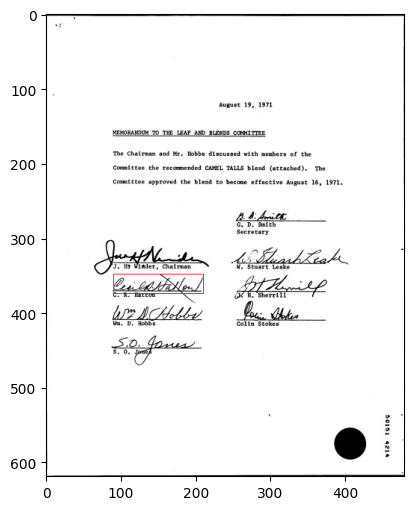

In [108]:
img = cv2.imread('tobacco_data_zhugy/scaled/saved_scaled/agw39d00.jpg')

img = cv2.rectangle(img, (90, 348), (90+120, 348+26), (255, 0, 0), 1)
plt.figure(figsize=(6, 6))
plt.imshow(img)

**Saving to CSV file**

In [109]:
data[['prev_filename', 'new_filename', 'filename', 'page_height', 'page_width', 'page_height_scaled', 'page_width_scaled', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height', 'x_scaled', 'y_scaled', 'w_scaled', 'h_scaled']].to_csv('tobacco_data_zhugy/tobacco_cleaned.csv', index=False)
data.head(100)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618,480
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618,480
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636,480
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618,480
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,bci73f00.tif,83.tif,1575,1200,NA,NA,DLLogo,None,488,292,56,64,bci73f00.jpg,195,116,22,25,630,480
96,bda6aa00.tif,84.tif,3300,2544,"Idle, J.R.",No,DLSignature,None,367,2350,560,180,bda6aa00.jpg,69,443,105,33,622,480
97,bda6aa00.tif,84.tif,3300,2544,NA,NA,DLLogo,None,236,138,266,364,bda6aa00.jpg,44,26,50,68,622,480
98,bea69d00.tif,85.tif,3273,2544,"Stuhl, O.",No,DLSignature,None,1638,1414,246,112,bea69d00.jpg,309,266,46,21,617,480


# Converting data to YOLOv5 format

In [110]:
def x_center(df):
  return int(df.x_scaled + (df.w_scaled/2))
def y_center(df):
  return int(df.y_scaled + (df.h_scaled/2))

def w_norm(df, col):
  return df[col]/df['page_width_scaled']
def h_norm(df, col):
  return df[col]/df['page_height_scaled']

df = pd.read_csv('tobacco_data_zhugy/tobacco_cleaned.csv')

le = preprocessing.LabelEncoder()
le.fit(df['category'])
print(le.classes_)
labels = le.transform(df['category'])
df['labels'] = labels


df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df.apply(w_norm, col='x_center',axis=1)
df['width_norm'] = df.apply(w_norm, col='w_scaled', axis=1)

df['y_center_norm'] = df.apply(h_norm, col='y_center',axis=1)
df['height_norm'] = df.apply(h_norm, col='h_scaled',axis=1)

df.head(20)

['DLLogo' 'DLSignature']


,prev_filename,new_filename,filename,page_height,page_width,page_height_scaled,page_width_scaled,AuthorID,Overlapped,category,...,y_scaled,w_scaled,h_scaled,labels,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,aah97e00-page02_1.tif,aah97e00-page02_1.jpg,0.tif,3296,2560,618,480,NaN,NaN,DLLogo,...,3,70,41,0,236,23,0.491667,0.145833,0.037217,0.066343
1,aah97e00-page02_2.tif,aah97e00-page02_2.jpg,1.tif,3296,2560,618,480,"Boder, J.B.",Yes,DLSignature,...,148,123,67,1,325,181,0.677083,0.256250,0.292880,0.108414
2,aam09c00.tif,aam09c00.jpg,2.tif,2292,1728,636,480,"Koplow, M.G.",Yes,DLSignature,...,395,210,50,1,333,420,0.693750,0.437500,0.660377,0.078616
3,aao54e00_2.tif,aao54e00_2.jpg,4.tif,3296,2560,618,480,"Landry, J.T.",Yes,DLSignature,...,132,117,38,1,341,151,0.710417,0.243750,0.244337,0.061489
4,abm69c00.tif,abm69c00.jpg,5.tif,2292,1728,636,480,"Feldman, J.D.",Yes,DLSignature,...,355,171,30,1,270,370,0.562500,0.356250,0.581761,0.047170
5,acr64d00.tif,acr64d00.jpg,6.tif,2292,1728,636,480,"Boffa, J.R.",Yes,DLSignature,...,500,128,50,1,310,525,0.645833,0.266667,0.825472,0.078616
6,adh36e00-page2_1.tif,adh36e00-page2_1.jpg,7.tif,3245,2560,608,480,NaN,NaN,DLLogo,...,3,67,41,0,254,23,0.529167,0.139583,0.037829,0.067434
7,adh36e00-page2_2.tif,adh36e00-page2_2.jpg,8.tif,3246,2560,608,480,"Krivisky, B.M.",Yes,DLSignature,...,449,168,80,1,315,489,0.656250,0.350000,0.804276,0.131579
8,adh36e00_1.tif,adh36e00_1.jpg,9.tif,3245,2560,608,480,NaN,NaN,DLLogo,...,3,65,41,0,254,23,0.529167,0.135417,0.037829,0.067434
9,adh36e00_2.tif,adh36e00_2.jpg,10.tif,3246,2560,608,480,"Krivisky, B.M.",Yes,DLSignature,...,450,166,81,1,315,490,0.656250,0.345833,0.805921,0.133224


# Moving images to train and valid folders

In [111]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_valid.shape)

(1207, 26) (135, 26)


**Creating relevant directories**

In [112]:
os.makedirs('tobacco_data_zhugy/tobacco_yolo_format/', exist_ok=True)
os.makedirs('tobacco_data_zhugy/tobacco_yolo_format/images/', exist_ok=True)
os.makedirs('tobacco_data_zhugy/tobacco_yolo_format/images/train/', exist_ok=True)
os.makedirs('tobacco_data_zhugy/tobacco_yolo_format/images/valid/', exist_ok=True)

os.makedirs('tobacco_data_zhugy/tobacco_yolo_format/labels/', exist_ok=True)
os.makedirs('tobacco_data_zhugy/tobacco_yolo_format/labels/train/', exist_ok=True)
os.makedirs('tobacco_data_zhugy/tobacco_yolo_format/labels/valid/', exist_ok=True)

**Segregating images and labels to train and valid**

In [113]:
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.new_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.new_filename), os.path.join(train_img_path,row.new_filename))
 
# Apply function
src_img_path = "tobacco_data_zhugy/scaled/saved_scaled/"
src_label_path = "tobacco_data_zhugy/groundtruth/xmlgroundtruth/"

train_img_path = "tobacco_data_zhugy/tobacco_yolo_format/images/train"
train_label_path = "tobacco_data_zhugy/tobacco_yolo_format/labels/train"

valid_img_path = "tobacco_data_zhugy/tobacco_yolo_format/images/valid"
valid_label_path = "tobacco_data_zhugy/tobacco_yolo_format/labels/valid"

segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

print("No. of Training images", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/images/train')))
print("No. of Training labels", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/labels/train')))

print("No. of valid images", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/images/valid')))
print("No. of valid labels", len(os.listdir('tobacco_data_zhugy/tobacco_yolo_format/labels/valid')))

No. of Training images 807
No. of Training labels 807
No. of valid images 129
No. of valid labels 129


**Deleting ipython checkpoints**

In [114]:
try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/images/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/images/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/labels/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('tobacco_data_zhugy/tobacco_yolo_format/labels/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass
